In [1]:
import re
import csv
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
# # input values
# appname = 'youtube'
# date = '2023.9.17'
# id_str = 0  # start sample index of the class
#
# # intermediate variable
# day = date[5:].replace('.','_')
# log_name = f'log_{appname}.txt'
# Data_file_location = f'F:/airscope/data/{date}_{appname}'
# # save file path
# data_folder = f'C:/Users/Jarvis/Desktop/Academic/Dissertation/Data/data_{day}'
# save_path = f'encoded_feature_{day}_{appname}.pkl'  # Encoded data pkl file
# save_encoded_path = f'./encoded_data_csv/encoded_feature_{day}_{appname}.csv'  # Encoded data csv file
# save_encoded_with_prb_path = f'./encoded_data_prb_csv/encoded_feature_with_prb_{day}_{appname}.csv'  # Encoded data csv file
# app_timelog_path = f'F:/airscope/data/{date}_{appname}/' + log_name  # the path for the time stamp
# airscope_csv_path  = Data_file_location+'/airscope.csv'

In [ ]:
def read_airscope_csv_file(file_path):
    df =pd.read_csv(file_path,sep=';')
    for idx, row in enumerate(df['tstamp']):
        str_time = datetime.datetime.fromtimestamp(row / 1000000.0).strftime('%H:%M:%S.%f')
        data_time = datetime.datetime.strptime(str_time,'%H:%M:%S.%f')
        df.loc[idx,'tstamp'] = data_time
    return df.loc[:,['tstamp',' dl_prb',' ul_prb']]

def read_app_timelog_list(file_path):
    app_timelog = open(file_path,'r')
    app_timelog_list = []
    for line in app_timelog:
        line = line.split('    ')
        start_time = datetime.datetime.strptime(line[1][11:], '%H:%M:%S')
        end_time = datetime.datetime.strptime(line[0][11:], '%H:%M:%S')
        time_periods = (start_time, end_time)
        app_timelog_list.append(time_periods)
    return app_timelog_list

def prb_map(prb_data, timelog_list):
    prb_map_list = []
    for periods in timelog_list:
        prb_within_periods = prb_data.loc[(prb_data['tstamp']>=periods[0])&(prb_data['tstamp']<=periods[1])]
        prb_within_periods = prb_within_periods.reset_index()
        prb_map_list.append(prb_within_periods)
    return prb_map_list

def percent_to_float(prb_percent):
    return float(prb_percent[1:-1])/100.0

def insert_prb(encoded_data_path, prb_list, save_path):
    encoded_data = pd.read_csv(encoded_data_path, sep=',')
    last_index = encoded_data['series_id'][len(encoded_data)-1] # in general should be 300
    encoded_data.insert(encoded_data.shape[1]-1,'dl_prb',0) # insert two new columns for prb values
    encoded_data.insert(encoded_data.shape[1]-1,'ul_prb',0)
    encoded_data.insert(encoded_data.shape[1]-1,'series_mean_dl_prb',0) # insert two new columns for prb values
    encoded_data.insert(encoded_data.shape[1]-1,'series_mean_ul_prb',0)

    for idx in range (int(last_index)+1):
        df_len_dl = encoded_data.loc[encoded_data['series_id']==idx, 'dl_prb'].shape[0]
        df_len_ul = encoded_data.loc[encoded_data['series_id']==idx, 'ul_prb'].shape[0]
        dl_prb_item = prb_list[idx][' dl_prb'].tolist()
        ul_prb_item = prb_list[idx][' ul_prb'].tolist()
        try:
            encoded_data.loc[encoded_data['series_id']==idx, 'dl_prb'] = dl_prb_item[:df_len_dl]
        except:
            print(idx)
            print(len(encoded_data.loc[encoded_data['series_id']==idx, 'dl_prb']))
            print(len(dl_prb_item[:df_len_dl]))
        encoded_data.loc[encoded_data['series_id']==idx, 'ul_prb'] = ul_prb_item[:df_len_ul]
        # Calcuate series mean prb value
        dl_series_mean_prb = np.mean(prb_list[idx][' dl_prb'][:df_len_dl].apply(percent_to_float))
        ul_series_mean_prb = np.mean(prb_list[idx][' ul_prb'][:df_len_ul].apply(percent_to_float))
        encoded_data.loc[encoded_data['series_id']==idx, 'series_mean_dl_prb'] = dl_series_mean_prb
        encoded_data.loc[encoded_data['series_id']==idx, 'series_mean_ul_prb'] =  ul_series_mean_prb
    encoded_data.to_csv(save_path,sep=',')
    return encoded_data

def series_mean_prb(prb_list, encoded_data):
    mean_prb_df = pd.DataFrame(columns=['dl_mean_prb','ul_mean_prb'])
    for idx, prb in enumerate(prb_list):
        df_len_dl = encoded_data.loc[encoded_data['series_id']==idx, 'dl_prb'].shape[0]
        df_len_ul = encoded_data.loc[encoded_data['series_id']==idx, 'ul_prb'].shape[0]
        prb_data = pd.DataFrame([[np.mean(prb[' dl_prb'][:df_len_dl].apply(percent_to_float)), \
                               np.mean(prb[' ul_prb'][:df_len_ul].apply(percent_to_float))]], columns=['dl_mean_prb','ul_mean_prb'])
        mean_prb_df = pd.concat([mean_prb_df, prb_data])
    return mean_prb_df

def mean_prb_sta(mean_prb_df, appname):
    mean_prb_sta = pd.cut(mean_prb_df['dl_mean_prb'], bins=[0,0.2,0.4,0.6,0.8,1.2],right=False)
    dl_counts = pd.value_counts(mean_prb_sta, sort=False)
    dl_plot = plt.bar(dl_counts.index.astype(str), dl_counts)
    plt.bar_label(dl_plot, dl_counts)
    plt.title(f'{appname} Downlink Mean Prb Statistics')
    plt.show()

    mean_prb_sta = pd.cut(mean_prb_df['ul_mean_prb'], bins=[0,0.2,0.4,0.6,0.8,1.2],right=False)
    ul_counts = pd.value_counts(mean_prb_sta, sort=False)
    ul_plot = plt.bar(ul_counts.index.astype(str), ul_counts)
    plt.bar_label(ul_plot, ul_counts)
    plt.title(f'{appname} Uplink Mean Prb Statistics')
    plt.show()

    plt.plot(range(len(mean_prb_df['dl_mean_prb'])), mean_prb_df['dl_mean_prb'])
    plt.plot(range(len(mean_prb_df['ul_mean_prb'])), mean_prb_df['ul_mean_prb'])
    plt.legend(['dl_mean_prb','ul_mean_prb'])
    plt.title(f'{appname} Instantaneous Prb Figure')
    plt.show()

def main(appname, date):
    """
    appname: name of the app
    date: e.g., '2023.9.9'
    id_str: start sample index of the class
    """
    # intermediate variable
    day = date[5:].replace('.','_')
    log_name = f'log_{appname}.txt'
    Data_file_location = f'F:/airscope/data/{date}_{appname}'
    # save file path
    save_encoded_path = f'./encoded_data_csv/encoded_feature_{day}_{appname}.csv'  # Encoded data csv file
    save_encoded_with_prb_path = f'./encoded_data_prb_csv/encoded_feature_with_prb_{day}_{appname}.csv'  # Encoded data csv file
    app_timelog_path = f'F:/airscope/data/{date}_{appname}/' + log_name  # the path for the time stamp
    airscope_csv_path  = Data_file_location+'/airscope.csv'

    prb_data = read_airscope_csv_file(airscope_csv_path)
    app_timelog_list = read_app_timelog_list(app_timelog_path)
    prb_list = prb_map(prb_data, app_timelog_list)
    encoded_data_with_prb = insert_prb(save_encoded_path, prb_list, save_encoded_with_prb_path)
    mean_prb_df = series_mean_prb(prb_list, encoded_data_with_prb)
    mean_prb_sta(mean_prb_df, appname)

In [13]:
a = np.ones(5)
a = a.astype(int)

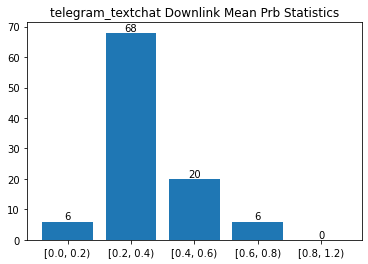

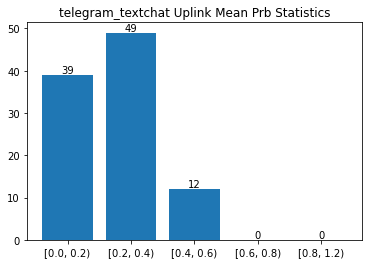

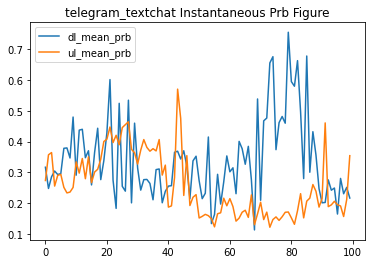

In [14]:
main('telegram_textchat','2023.9.24')

In [4]:
# prb_data = read_airscope_csv_file(airscope_csv_path)
# app_timelog_list = read_app_timelog_list(app_timelog_path)
# prb_list = prb_map(prb_data, app_timelog_list)
# encoded_data_with_prb = insert_prb(save_encoded_path, prb_list, save_encoded_with_prb_path)
# mean_prb_df = series_mean_prb(prb_list, encoded_data_with_prb)
# mean_prb_sta(mean_prb_df, appname)

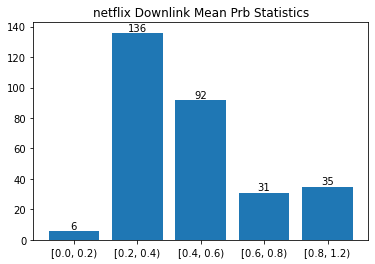

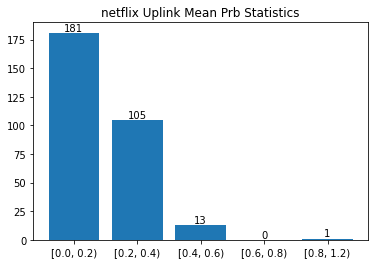

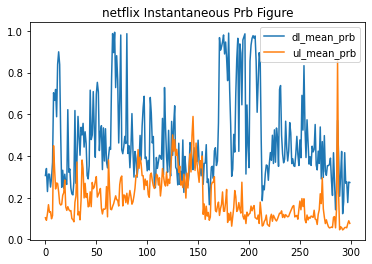

43
525
300
Error happens: spotify


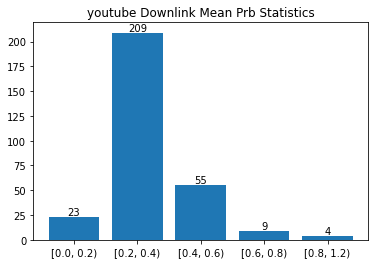

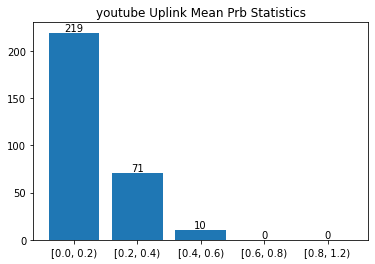

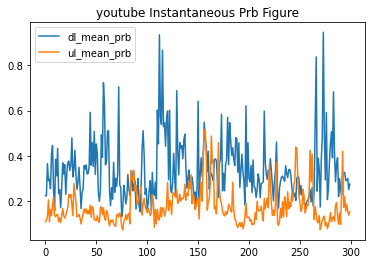

Error happens: applemusic
Error happens: youtubemusic
Error happens: telegram_video
Error happens: whatsapp_video
Error happens: ins
Error happens: x


In [5]:
encoded_data_list = os.listdir('./encoded_data_csv')
for data_file in encoded_data_list:
    file_name = data_file.split('_')
    try:
        appname = appname = file_name[4:][0]+'_'+file_name[4:][1][:-4]
    except:
        appname = file_name[4:][0][:-4]
    date = '2023.{mon}.{day}'.format(mon=file_name[2],day=file_name[3])
    # print(appname,date)
    try:
        main(appname,date)
    except:
        print(f'Error happens: {appname}')